# Trabalho Acetilcolinesterase

In [87]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix
from PIL import Image
#import itertools
import os
#import shutil
#import random
#import glob
import matplotlib.pyplot as plt

#import warnings

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
#warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [88]:
train_path = './data/train/'
test_path = './data/test/' 

In [89]:
tf.config.list_physical_devices()


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [90]:
os.listdir(train_path)

['negativo', 'positivo']

In [91]:
def tensor_to_image(tensor):
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)

In [128]:
def data_augmenter():
    '''
    Create a Sequential model composed of 2 layers
    Returns:
        tf.keras.Sequential
    '''
    ### START CODE HERE
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(tf.keras.layers.RandomFlip('horizontal'))
    data_augmentation.add(tf.keras.layers.RandomRotation(0.2))
    ### END CODE HERE
    
    return data_augmentation

## Import Images do Disco

In [139]:
#train_batch = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
#    .flow_from_directory(directory=train_path, target_size=(224,224), classes=['positivo', 'negativo'])
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
def get_ds(image_size=IMG_SIZE):
    train_ds, valid_ds = tf.keras.utils.image_dataset_from_directory(
        train_path,
        labels='inferred',
        label_mode='int',
        class_names=['negativo', 'positivo'],
        color_mode='rgb',
        batch_size=10,
        image_size=image_size,
        shuffle=True,
        seed=33,
        validation_split=.2,
        subset='both',
    )

    return train_ds, valid_ds

## Classes presentes no Dataset


In [140]:
train_ds, valid_ds = get_ds()
class_names = train_ds.class_names
print(class_names)


Found 100 files belonging to 2 classes.
Using 80 files for training.
Using 20 files for validation.
['negativo', 'positivo']


### Amostra de Imagens e Classes no Dataset

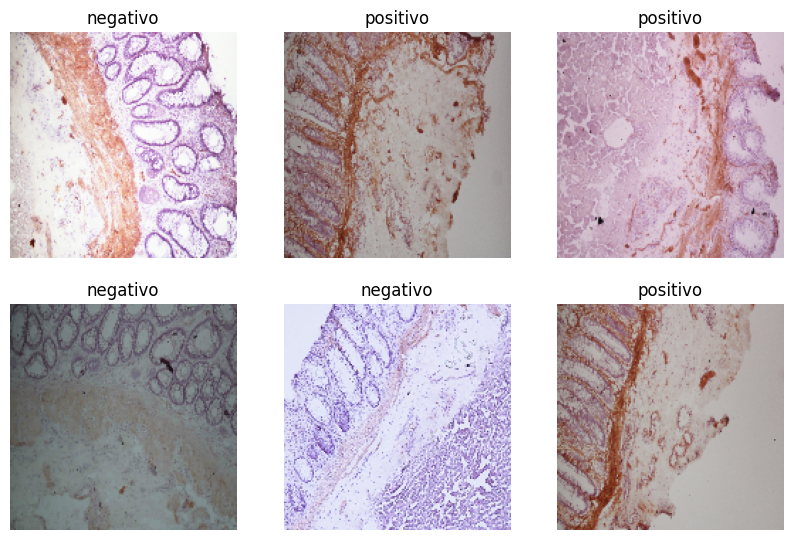

In [141]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


## Criando o modelo CNN simples 
### L1
- Filter size 3x3x32
- Activation Relu
- Padding 'Same'
- stride 2
### L2
- Filter size 3x3x64
- Activation Relu
- Padding 'Same'
- stride 2
### FC
- Activation 'linear'
- Classes 2 (pos, neg)

In [142]:
model = Sequential([
    
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same' ),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=2, activation='linear')
])

In [143]:
model.compile(optimizer=Adam(learning_rate=0.001), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [144]:
history = model.fit(x=train_ds,
    validation_data= valid_ds,
    epochs=20,
    verbose=2
)

Epoch 1/20
8/8 - 1s - loss: 556.9967 - accuracy: 0.5250 - val_loss: 114.9408 - val_accuracy: 0.4000 - 1s/epoch - 173ms/step
Epoch 2/20
8/8 - 0s - loss: 19.5651 - accuracy: 0.5750 - val_loss: 0.9768 - val_accuracy: 0.7000 - 388ms/epoch - 49ms/step
Epoch 3/20
8/8 - 0s - loss: 0.9023 - accuracy: 0.6875 - val_loss: 0.5450 - val_accuracy: 0.8500 - 372ms/epoch - 46ms/step
Epoch 4/20
8/8 - 0s - loss: 0.6241 - accuracy: 0.7125 - val_loss: 0.6359 - val_accuracy: 0.5000 - 444ms/epoch - 56ms/step
Epoch 5/20
8/8 - 0s - loss: 0.5483 - accuracy: 0.7250 - val_loss: 0.6369 - val_accuracy: 0.6000 - 406ms/epoch - 51ms/step
Epoch 6/20
8/8 - 0s - loss: 0.5267 - accuracy: 0.7375 - val_loss: 0.8392 - val_accuracy: 0.5000 - 366ms/epoch - 46ms/step
Epoch 7/20
8/8 - 0s - loss: 0.5057 - accuracy: 0.7875 - val_loss: 0.5743 - val_accuracy: 0.8000 - 406ms/epoch - 51ms/step
Epoch 8/20
8/8 - 0s - loss: 0.4534 - accuracy: 0.8250 - val_loss: 1.4033 - val_accuracy: 0.4500 - 396ms/epoch - 50ms/step
Epoch 9/20
8/8 - 0s -

### Gráfico da Acurácia

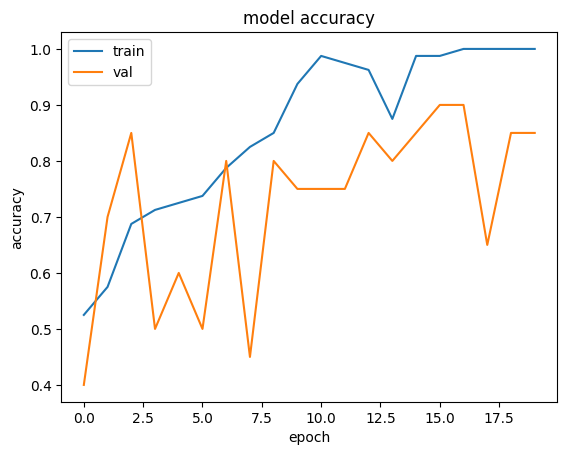

In [145]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Gráfico da Loss Function 

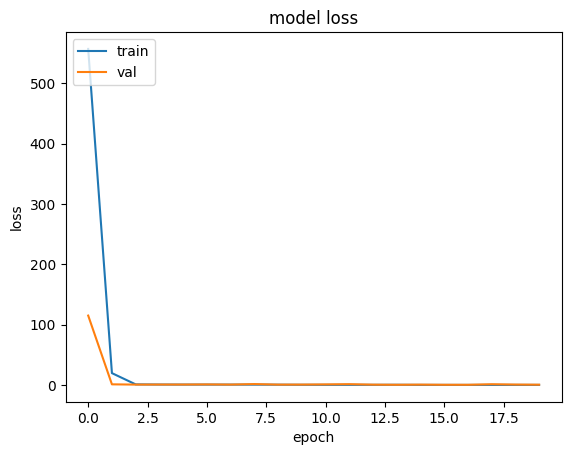

In [146]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Predict sobre uma nova Imagem

In [149]:
# load image via tf.io
#img = tf.io.read_file(fname)

# convert to tensor (specify 3 channels explicitly since png files contains additional alpha channel)
# set the dtypes to align with pytorch for comparison since it will use uint8 by default
#tensor = tf.io.decode_image(img, channels=3, dtype=tf.dtypes.float32)
# (384, 470, 3)
#plt.imshow(tensor)
# resize tensor to 224 x 224
#tensor = tf.image.resize(tensor, [256, 256])
# (224, 224, 3)

# add another dimension at the front to get NHWC shape
#input_tensor = tf.expand_dims(tensor, axis=0)
# (1, 224, 224, 3)
#predict = model.predict(input_tensor)


def test_image(fname, model):
    fname = test_path + fname
    image = Image.open(fname).resize((160, 160))

    plt.imshow(image)
    image_t = tf.convert_to_tensor(image)
    input_tensor = tf.expand_dims(image_t, axis=0)

    predict = model.predict(input_tensor)


    predict_p=tf.nn.softmax(predict)
    print(f"vetor de Logits: {predict}")
    print(f"vetor de Probabilidade: {predict_p}")
    print(f"Total of Predictions: {np.sum(predict_p):0.3f}")


    print ("y = " + str(np.argmax(predict)) + ", 2L-layer model predicts a \"" + class_names[int(np.argmax(predict_p))] +  "\" picture.")

1/1 [==============================] - 0s 82ms/step
vetor de Logits: [[ 1.1927894 -3.3870819]]
vetor de Probabilidade: [[0.98984796 0.01015209]]
Total of Predictions: 1.000
y = 0, 2L-layer model predicts a "negativo" picture.


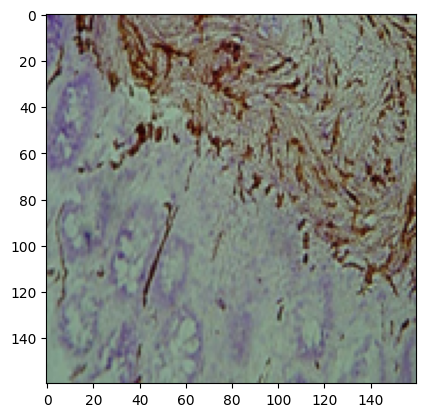

In [150]:
test_image("test_pos-2.jpg", model) 

1/1 [==============================] - 0s 17ms/step
vetor de Logits: [[-3.3683007  2.7070591]]
vetor de Probabilidade: [[0.00229355 0.9977064 ]]
Total of Predictions: 1.000
y = 1, 2L-layer model predicts a "positivo" picture.


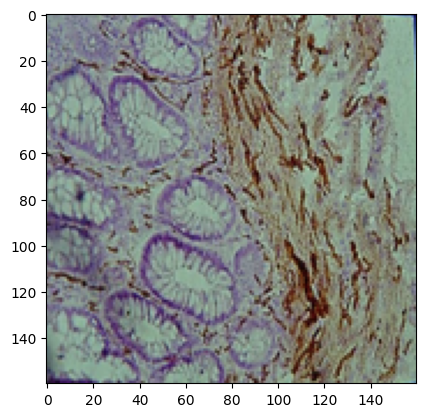

In [151]:
test_image("test_pos-1.jpg", model) 

In [152]:
IMG_SIZE = 480

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])



In [153]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])


In [154]:
train_ds = train_ds.shuffle(1000)

In [155]:
model = Sequential([
    resize_and_rescale,
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same' ),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same' ),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=2, activation='linear')
])

In [156]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [157]:
history = model.fit(x=train_ds,
    validation_data= valid_ds,
    epochs=20,
    verbose=2
)


Epoch 1/20
8/8 - 1s - loss: 2.8283 - accuracy: 0.4750 - val_loss: 4.1154 - val_accuracy: 0.4000 - 1s/epoch - 181ms/step
Epoch 2/20
8/8 - 1s - loss: 2.1148 - accuracy: 0.4000 - val_loss: 0.7412 - val_accuracy: 0.4000 - 632ms/epoch - 79ms/step
Epoch 3/20
8/8 - 1s - loss: 1.1448 - accuracy: 0.5000 - val_loss: 0.7524 - val_accuracy: 0.5500 - 612ms/epoch - 76ms/step
Epoch 4/20
8/8 - 1s - loss: 0.9754 - accuracy: 0.4875 - val_loss: 1.3343 - val_accuracy: 0.4000 - 650ms/epoch - 81ms/step
Epoch 5/20
8/8 - 1s - loss: 0.8735 - accuracy: 0.4750 - val_loss: 0.6315 - val_accuracy: 0.6500 - 576ms/epoch - 72ms/step
Epoch 6/20
8/8 - 1s - loss: 0.6203 - accuracy: 0.6125 - val_loss: 0.6766 - val_accuracy: 0.8000 - 550ms/epoch - 69ms/step
Epoch 7/20
8/8 - 1s - loss: 0.5331 - accuracy: 0.8000 - val_loss: 0.6344 - val_accuracy: 0.7500 - 637ms/epoch - 80ms/step
Epoch 8/20
8/8 - 1s - loss: 0.5078 - accuracy: 0.8250 - val_loss: 0.6264 - val_accuracy: 0.7500 - 546ms/epoch - 68ms/step
Epoch 9/20
8/8 - 1s - loss

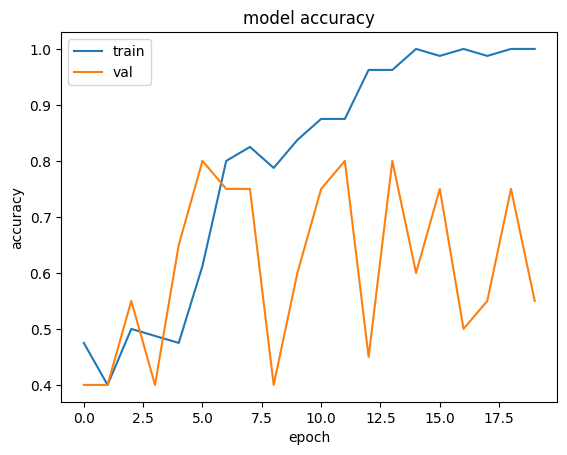

In [158]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

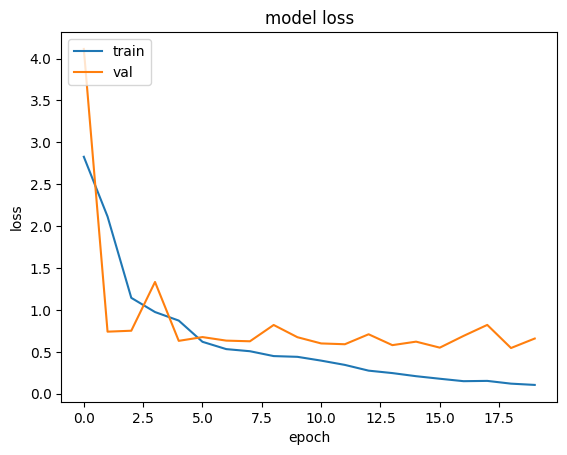

In [159]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

1/1 [==============================] - 0s 51ms/step
vetor de Logits: [[-0.27225006  0.27916548]]
vetor de Probabilidade: [[0.36553603 0.6344639 ]]
Total of Predictions: 1.000
y = 1, 2L-layer model predicts a "positivo" picture.


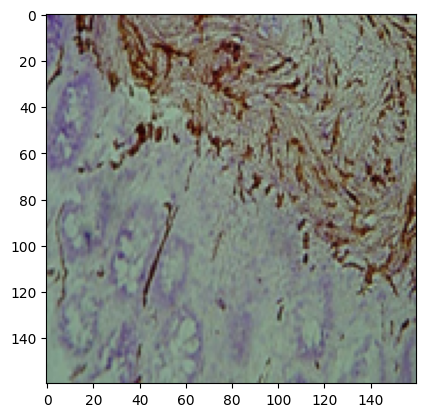

In [160]:
test_image("test_pos-2.jpg", model) 



# Transfer Learning Model: EfficientNet V2 B0
<div style='border-width: 2px;
              border-bottom-width:4px;
              border-bottom-color:#B6EADA;
              border-bottom-style: solid;'></div>
<br>  

EfficientNetV2 is a convolutional neural network that has faster training speed and better parameter efficiency than previous EfficientNetV1 models. To develop these models, the authors use a combination of training-aware neural architecture search and scaling, to jointly optimize training speed. The models were searched from the search space enriched with new ops such as Fused-MBConv.

<center>
    <figure>
        <img src="https://i.postimg.cc/vBSTR3V0/59864ee4.png" alt ="MBConv and Fused-MBConv" style='width: 400px;'>
        <figcaption>
            Image Source: <a href="https://wandb.ai/wandb_fc/pytorch-image-models/reports/EfficientNetV2--Vmlldzo2NTkwNTQ">[Source]</a></figcaption>
    </figure>
</center>

**For more information follow the links below:**
> - EfficientNet V2 Paper (2021): [EfficientNetV2: Smaller Models and Faster Training](https://arxiv.org/pdf/2104.00298v2.pdf)
> - [EfficientNet: Improving Accuracy and Efficiency through AutoML and Model Scaling](https://ai.googleblog.com/2019/05/efficientnet-improving-accuracy-and.html)
> - [Wandb: EfficientNetV2](https://wandb.ai/wandb_fc/pytorch-image-models/reports/EfficientNetV2--Vmlldzo2NTkwNTQ)

<a id="tfhub"></a>
## TensorFlow Hub

TensorFlow Hub is a repository of trained machine learning models ready for fine-tuning and deployable anywhere. Reuse trained models like BERT and Faster R-CNN with just a few lines of code.

In this section we'll be using pre-trained models from TensorFlow Hub. 

> For more information on TensorFlow Hub or if you would like to access the same models in PyTorch/JAX, check out the following links:
> - [TensorFlow Hub](https://www.tensorflow.org/hub)
> - [HuggingFace🤗](https://huggingface.co/)

In [161]:
import tensorflow_hub as hub

In [162]:
# Here's a function to get any model/preprocessor from tensorflow hub
def get_tfhub_model(model_link, model_name, model_trainable=False):
    return hub.KerasLayer(model_link,
                          trainable=model_trainable,
                          name=model_name)

In [163]:
# Get EfficientNet V2 B0 here
efficientnet_v2_url = 'https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b0/feature_vector/2'
model_name = 'efficientnet_v2_b0'

# Set trainable to False for inference-only 
set_trainable=False

efficientnet_v2_b0 = get_tfhub_model(efficientnet_v2_url, 
                                     model_name, 
                                     model_trainable=set_trainable)

In [164]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(224, 224),
  layers.Rescaling(1./255)
])



In [165]:
def efficientnet_v2_model():
    
    #initializer = tf.keras.initializers.GlorotNormal(seed=123)
    initializer = tf.keras.initializers.HeNormal(seed=123)

    
    efficientnet_v2_sequential = Sequential([
        resize_and_rescale,
        efficientnet_v2_b0,
        layers.Dropout(0.2),
        layers.Dense(512, activation='relu', kernel_initializer=initializer),
        layers.Dense(256, activation='relu', kernel_initializer=initializer),
        layers.Dense(128, activation='relu', kernel_initializer=initializer),
        layers.Dense(64, activation='relu', kernel_initializer=initializer),
        layers.Dense(32, activation='relu', kernel_initializer=initializer),
        layers.Dense(2, dtype=tf.float32, activation='linear', kernel_initializer=initializer)
    ], name='efficientnet_v2_sequential_model')
    
    return efficientnet_v2_sequential

In [166]:
# Generate Model
model_efficientnet_v2 = efficientnet_v2_model()

model_efficientnet_v2.build([None, 224, 224, 3]) 

# Generate Summary of the Model
model_efficientnet_v2.summary()

Model: "efficientnet_v2_sequential_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_22 (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 efficientnet_v2_b0 (KerasLa  (None, 1280)             5919312   
 yer)                                                            
                                                                 
 dropout_9 (Dropout)         (None, 1280)              0         
                                                                 
 dense_44 (Dense)            (None, 512)               655872    
                                                                 
 dense_45 (Dense)            (None, 256)               131328    
                                                                 
 dense_46 (Dense)            (None, 128)               32896     
                                  

In [167]:
model_efficientnet_v2.compile(optimizer=Adam(learning_rate=0.0001), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [168]:
train_ds, valid_ds = get_ds()


Found 100 files belonging to 2 classes.
Using 80 files for training.
Using 20 files for validation.


In [169]:
history = model_efficientnet_v2.fit(x=train_ds,
    validation_data= valid_ds,
    epochs=20,
    verbose=2
)

Epoch 1/20
8/8 - 7s - loss: 0.9665 - accuracy: 0.5250 - val_loss: 0.8018 - val_accuracy: 0.6000 - 7s/epoch - 936ms/step
Epoch 2/20
8/8 - 1s - loss: 0.8629 - accuracy: 0.5125 - val_loss: 0.7059 - val_accuracy: 0.6000 - 500ms/epoch - 63ms/step
Epoch 3/20
8/8 - 0s - loss: 0.6346 - accuracy: 0.6125 - val_loss: 0.7105 - val_accuracy: 0.6000 - 484ms/epoch - 61ms/step
Epoch 4/20
8/8 - 1s - loss: 0.6242 - accuracy: 0.6250 - val_loss: 0.6843 - val_accuracy: 0.6000 - 504ms/epoch - 63ms/step
Epoch 5/20
8/8 - 1s - loss: 0.5772 - accuracy: 0.7250 - val_loss: 0.6200 - val_accuracy: 0.6000 - 529ms/epoch - 66ms/step
Epoch 6/20
8/8 - 0s - loss: 0.5455 - accuracy: 0.7500 - val_loss: 0.6387 - val_accuracy: 0.5500 - 480ms/epoch - 60ms/step
Epoch 7/20
8/8 - 0s - loss: 0.5283 - accuracy: 0.7500 - val_loss: 0.6210 - val_accuracy: 0.7000 - 445ms/epoch - 56ms/step
Epoch 8/20
8/8 - 1s - loss: 0.4536 - accuracy: 0.8000 - val_loss: 0.5963 - val_accuracy: 0.7500 - 516ms/epoch - 65ms/step
Epoch 9/20
8/8 - 0s - loss

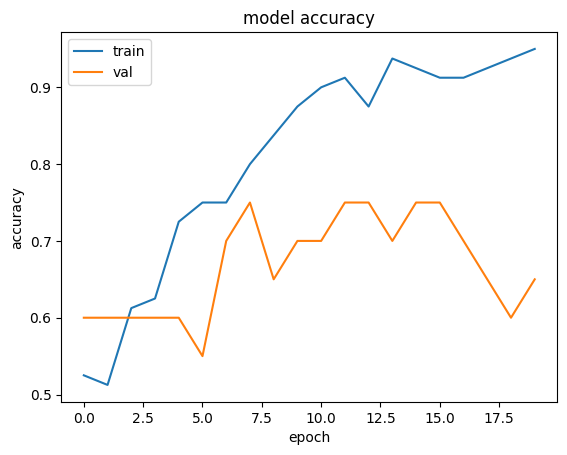

In [170]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

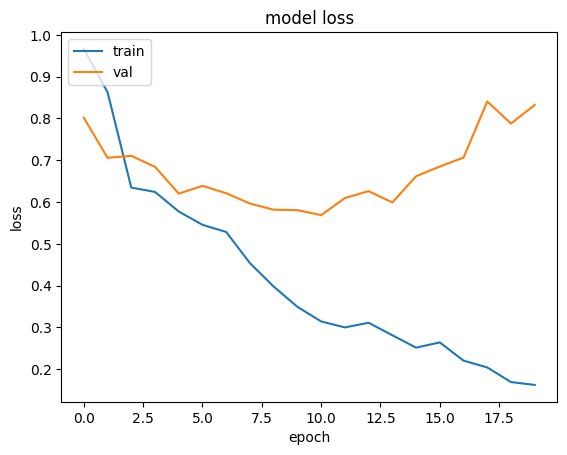

In [171]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

1/1 [==============================] - 1s 569ms/step
vetor de Logits: [[-1.3858304  0.7149952]]
vetor de Probabilidade: [[0.10901661 0.8909834 ]]
Total of Predictions: 1.000
y = 1, 2L-layer model predicts a "positivo" picture.


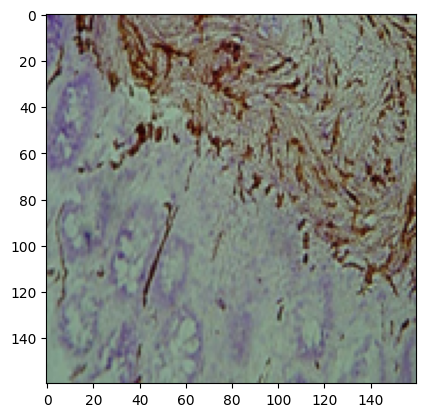

In [172]:
test_image("test_pos-2.jpg", model_efficientnet_v2) 

1/1 [==============================] - 0s 16ms/step
vetor de Logits: [[-1.3400007  1.287536 ]]
vetor de Probabilidade: [[0.0673871  0.93261296]]
Total of Predictions: 1.000
y = 1, 2L-layer model predicts a "positivo" picture.


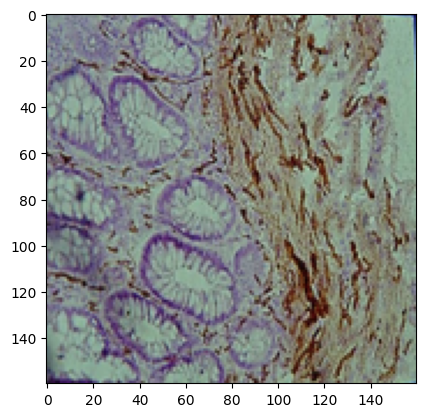

In [173]:
test_image("test_pos-1.jpg", model) 

In [174]:
def V22_model(image_shape=(160,160), data_augmentation=data_augmenter()):
    ''' Define a tf.keras model for binary classification out of the MobileNetV2 model
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
    Returns:
    Returns:
        tf.keras.model
    '''
    
    
    input_shape = image_shape + (3,)
    
    ### START CODE HERE
    
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False, # <== Important!!!!
                                                   weights='imagenet') # From imageNet
    
    # freeze the base model by making it non trainable
    base_model.trainable = False 

    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape) 
    
    # apply data augmentation to the inputs
    x = data_augmentation(inputs)
    
    # data preprocessing using the same weights the model was trained on
    x = tf.keras.applications.efficientnet_v2.preprocess_input(x) 
    
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False) 
    
    # add the new Binary classification layers
    
    # use global avg pooling to summarize the info in each channel
    x = tf.keras.layers.GlobalAveragePooling2D()(x) 
    # include dropout with probability of 0.2 to avoid overfitting
    x = tf.keras.layers.Dropout(rate=0.2)(x)
        
    # use a prediction layer with one neuron (as a binary classifier only needs one)
    outputs = tf.keras.layers.Dense(units=1, activation='linear')(x)
    
    ### END CODE HERE
    
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [175]:
model2 = V22_model()
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [176]:
history = model2.fit(x=train_ds,
    validation_data= valid_ds,
    epochs=20,
    verbose=2
)

Epoch 1/20


8/8 - 5s - loss: 0.7716 - accuracy: 0.5375 - val_loss: 0.9632 - val_accuracy: 0.3000 - 5s/epoch - 608ms/step
Epoch 2/20
8/8 - 1s - loss: 0.8788 - accuracy: 0.4625 - val_loss: 0.9484 - val_accuracy: 0.5000 - 658ms/epoch - 82ms/step
Epoch 3/20
8/8 - 1s - loss: 0.7610 - accuracy: 0.5250 - val_loss: 0.7588 - val_accuracy: 0.5000 - 646ms/epoch - 81ms/step
Epoch 4/20
8/8 - 1s - loss: 0.7105 - accuracy: 0.5750 - val_loss: 0.7651 - val_accuracy: 0.4500 - 579ms/epoch - 72ms/step
Epoch 5/20
8/8 - 1s - loss: 0.7035 - accuracy: 0.5750 - val_loss: 0.7386 - val_accuracy: 0.5000 - 741ms/epoch - 93ms/step
Epoch 6/20
8/8 - 1s - loss: 0.7544 - accuracy: 0.5500 - val_loss: 0.7709 - val_accuracy: 0.5000 - 636ms/epoch - 79ms/step
Epoch 7/20
8/8 - 1s - loss: 0.6293 - accuracy: 0.6500 - val_loss: 0.7184 - val_accuracy: 0.5000 - 575ms/epoch - 72ms/step
Epoch 8/20
8/8 - 1s - loss: 0.6570 - accuracy: 0.5875 - val_loss: 0.7208 - val_accuracy: 0.5500 - 617ms/epoch - 77ms/step
Epoch 9/20
8/8 - 1s - loss: 0.6774 - 

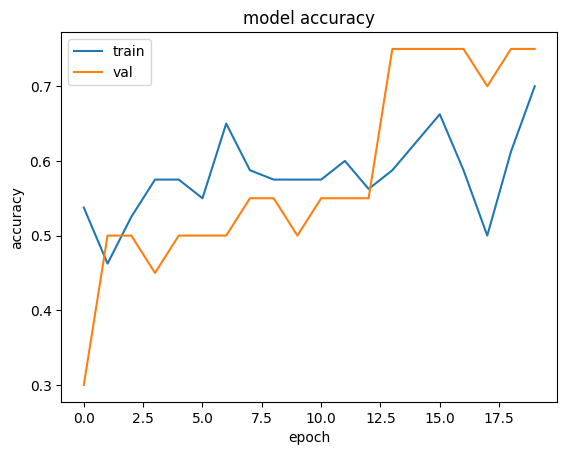

In [177]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

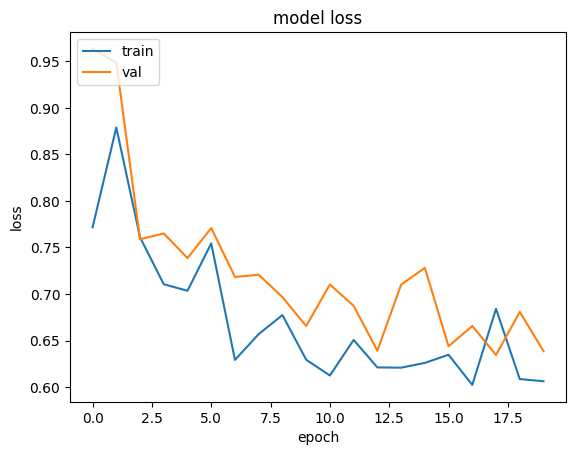

In [178]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

1/1 [==============================] - 0s 17ms/step
vetor de Logits: [[-1.3400007  1.287536 ]]
vetor de Probabilidade: [[0.0673871  0.93261296]]
Total of Predictions: 1.000
y = 1, 2L-layer model predicts a "positivo" picture.


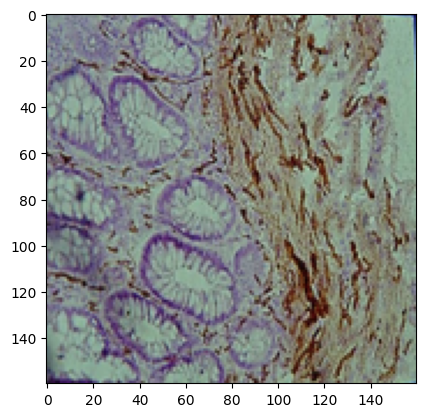

In [179]:
test_image("test_pos-1.jpg", model) 